# SVM 之SMO算法

### 支持向量机是一种非常有用的机器学习算法，在传统机器学习算法中，占据很重要的位置，由于间隔最大化使得支持向量具有非常大的容忍性，因此传统机器学习算法中，支持向量机是非常火的一门算法。但是支持向量机需要有非常深的数学功底，本人也看了很长时间勉强将支持向量机的对偶以及SMO算法看懂，本文就对支持向量机做出一个简单的实现，为了将来的需要。

首先引入问题，支持向量机的目标是找到一个超平面使得分类间隔最大化，因此需要求解

$$
max_{w,b} \frac{2}{||w||}
$$
$$
在条件 y_i(w^Tx_i+b)>=1
$$

因此，该问题可以重写成

$$
min_{w,b} \frac{1}{2}{||w||}^2
$$
$$
在条件 y_i(w^Tx_i+b)>=1
$$

这样，对于多个变量的约束极值问题，很容易想到使用拉格朗日乘子法

$$
L(w,b,\alpha) = \frac{1}{2}{||w||}^2 + \sum{\alpha_i(1-y_i(w^Tx_i+b))}
$$

注意到该函数有三个参数，我们需要求解$\alpha$，于是对$w,b$求导，并令其为0

$$
w = \sum{\alpha_iy_ix_i}
$$
$$
0 = \sum{\alpha_iy_i}
$$

将其带入拉格朗日函数

$$
max_\alpha W(\alpha)=\sum{\alpha_i}-\frac{1}{2}\sum\sum \alpha_i\alpha_jy_iy_j{x_i}^Tx_j
$$

约束条件为

$$
\sum{\alpha_iy_i} = 0
$$

$$
\alpha_i >=0 i=1,2,..m
$$

对于这种优化问题，有多种解法，可以使用库，这里我们使用经典的算法SMO

### SMO算法

SMO算法的思想就是先选择两个变量，由于约束的存在，因此两个变量的其中一个可以由另一个变量来表示，然后原问题就转换成一元的优化问题。


参考
1. http://cs229.stanford.edu/syllabus.html
2. http://jonchar.net/notebooks/SVM/
3. http://web.cs.iastate.edu/~honavar/smo-svm.pdf

## SMO算法实现

In [1]:
# 导入库


import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.preprocessing import StandardScaler

In [5]:
class SMOModel:    
    def __init__(self, X, y, C, kernel, alphas, b, errors):
        self.X = X               
        self.y = y               
        self.C = C               
        self.kernel = kernel  # 核函数
        self.alphas = alphas  # 拉格朗日乘子   
        self.b = b               
        self.errors = errors     
        self._obj = []           
        self.m = len(self.X)     

In [6]:

def linear_kernel(x, y, b=1):
    return x @ y.T + b 


def gaussian_kernel(x, y, sigma=1):
    if np.ndim(x) == 1 and np.ndim(y) == 1:
        result = np.exp(- np.linalg.norm(x - y) / (2 * sigma ** 2))
    elif (np.ndim(x) > 1 and np.ndim(y) == 1) or (np.ndim(x) == 1 and np.ndim(y) > 1):
        result = np.exp(- np.linalg.norm(x - y, axis=1) / (2 * sigma ** 2))
    elif np.ndim(x) > 1 and np.ndim(y) > 1:
        result = np.exp(- np.linalg.norm(x[:, np.newaxis] - y[np.newaxis, :], axis=2) / (2 * sigma ** 2))
    return result

In [7]:
x_len, y_len = 5, 10

In [8]:
## 定义目标函数
def objective_function(alphas, target, kernel, X_train):
    return np.sum(alphas) - 0.5 * np.sum(target * target * kernel(X_train, X_train) * alphas * alphas)

def decision_function(alphas, target, kernel, X_train, x_test, b):    
    result = (alphas * target) @ kernel(X_train, x_test) - b
    return result

In [39]:
#### 参考网上代码 画边界

def plot_decision_boundary(model, ax, resolution=100, colors=('b', 'k', 'r')):
        """Plots the model's decision boundary on the input axes object.
        Range of decision boundary grid is determined by the training data.
        Returns decision boundary grid and axes object (`grid`, `ax`)."""
        
        # Generate coordinate grid of shape [resolution x resolution]
        # and evaluate the model over the entire space
        xrange = np.linspace(model.X[:,0].min(), model.X[:,0].max(), resolution)
        yrange = np.linspace(model.X[:,1].min(), model.X[:,1].max(), resolution)
        grid = [[decision_function(model.alphas, model.y,
                                   model.kernel, model.X,
                                   np.array([xr, yr]), model.b) for yr in yrange] for xr in xrange]
        grid = np.array(grid).reshape(len(xrange), len(yrange))
        
        # Plot decision contours using grid and
        # make a scatter plot of training data
        ax.contour(xrange, yrange, grid, (-1, 0, 1), linewidths=(1, 1, 1),
                   linestyles=('--', '-', '--'), colors=colors)
        ax.scatter(model.X[:,0], model.X[:,1],
                   c=model.y, cmap=plt.cm.viridis, lw=0, alpha=0.5)
        
        # Plot support vectors (non-zero alphas)
        # as circled points (linewidth > 0)
        mask = model.alphas != 0.0
        ax.scatter(model.X[:,0][mask], model.X[:,1][mask],
                   c=model.y[mask], cmap=plt.cm.viridis)
        
        return grid, ax

In [41]:
def take_step(i1, i2, model):
    
    # Skip if chosen alphas are the same
    if i1 == i2:
        return 0, model
    
    alph1 = model.alphas[i1]
    alph2 = model.alphas[i2]
    y1 = model.y[i1]
    y2 = model.y[i2]
    E1 = model.errors[i1]
    E2 = model.errors[i2]
    s = y1 * y2
    
    # Compute L & H, the bounds on new possible alpha values
    if (y1 != y2):
        L = max(0, alph2 - alph1)
        H = min(model.C, model.C + alph2 - alph1)
    elif (y1 == y2):
        L = max(0, alph1 + alph2 - model.C)
        H = min(model.C, alph1 + alph2)
    if (L == H):
        return 0, model

    # Compute kernel & 2nd derivative eta
    k11 = model.kernel(model.X[i1], model.X[i1])
    k12 = model.kernel(model.X[i1], model.X[i2])
    k22 = model.kernel(model.X[i2], model.X[i2])
    eta = 2 * k12 - k11 - k22
    
    # Compute new alpha 2 (a2) if eta is negative
    if (eta < 0):
        a2 = alph2 - y2 * (E1 - E2) / eta
        # Clip a2 based on bounds L & H
        if L < a2 < H:
            a2 = a2
        elif (a2 <= L):
            a2 = L
        elif (a2 >= H):
            a2 = H
            
    # If eta is non-negative, move new a2 to bound with greater objective function value
    else:
        alphas_adj = model.alphas.copy()
        alphas_adj[i2] = L
        # objective function output with a2 = L
        Lobj = objective_function(alphas_adj, model.y, model.kernel, model.X) 
        alphas_adj[i2] = H
        # objective function output with a2 = H
        Hobj = objective_function(alphas_adj, model.y, model.kernel, model.X)
        if Lobj > (Hobj + eps):
            a2 = L
        elif Lobj < (Hobj - eps):
            a2 = H
        else:
            a2 = alph2
            
    # Push a2 to 0 or C if very close
    if a2 < 1e-8:
        a2 = 0.0
    elif a2 > (model.C - 1e-8):
        a2 = model.C
    
    # If examples can't be optimized within epsilon (eps), skip this pair
    if (np.abs(a2 - alph2) < eps * (a2 + alph2 + eps)):
        return 0, model
    
    # Calculate new alpha 1 (a1)
    a1 = alph1 + s * (alph2 - a2)
    
    # Update threshold b to reflect newly calculated alphas
    # Calculate both possible thresholds
    b1 = E1 + y1 * (a1 - alph1) * k11 + y2 * (a2 - alph2) * k12 + model.b
    b2 = E2 + y1 * (a1 - alph1) * k12 + y2 * (a2 - alph2) * k22 + model.b
    
    # Set new threshold based on if a1 or a2 is bound by L and/or H
    if 0 < a1 and a1 < C:
        b_new = b1
    elif 0 < a2 and a2 < C:
        b_new = b2
    # Average thresholds if both are bound
    else:
        b_new = (b1 + b2) * 0.5

    # Update model object with new alphas & threshold
    model.alphas[i1] = a1
    model.alphas[i2] = a2
    
    # Update error cache
    # Error cache for optimized alphas is set to 0 if they're unbound
    for index, alph in zip([i1, i2], [a1, a2]):
        if 0.0 < alph < model.C:
            model.errors[index] = 0.0
    
    # Set non-optimized errors based on equation 12.11 in Platt's book
    non_opt = [n for n in range(model.m) if (n != i1 and n != i2)]
    model.errors[non_opt] = model.errors[non_opt] + \
                            y1*(a1 - alph1)*model.kernel(model.X[i1], model.X[non_opt]) + \
                            y2*(a2 - alph2)*model.kernel(model.X[i2], model.X[non_opt]) + model.b - b_new
    
    # Update model threshold
    model.b = b_new
    
    return 1, model

In [50]:
def examine_example(i2, model):
    
    y2 = model.y[i2]
    alph2 = model.alphas[i2]
    E2 = model.errors[i2]
    r2 = E2 * y2

    if ((r2 < -tol and alph2 < model.C) or (r2 > tol and alph2 > 0)):
        
        if len(model.alphas[(model.alphas != 0) & (model.alphas != model.C)]) > 1:
            if model.errors[i2] > 0:
                i1 = np.argmin(model.errors)
            elif model.errors[i2] <= 0:
                i1 = np.argmax(model.errors)
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
            
        for i1 in np.roll(np.where((model.alphas != 0) & (model.alphas != model.C))[0],
                          np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
        
        for i1 in np.roll(np.arange(model.m), np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
    
    return 0, model

In [51]:
def train(model):
    
    numChanged = 0
    examineAll = 1

    while(numChanged > 0) or (examineAll):
        numChanged = 0
        if examineAll:
            for i in range(model.alphas.shape[0]):
                examine_result, model = examine_example(i, model)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective_function(model.alphas, model.y, model.kernel, model.X)
                    model._obj.append(obj_result)
        else:
            for i in np.where((model.alphas != 0) & (model.alphas != model.C))[0]:
                examine_result, model = examine_example(i, model)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective_function(model.alphas, model.y, model.kernel, model.X)
                    model._obj.append(obj_result)
        if examineAll == 1:
            examineAll = 0
        elif numChanged == 0:
            examineAll = 1
        
    return model

### 构造数据集

In [52]:
X_train, y = make_blobs(n_samples=1000, centers=2,
                        n_features=2, random_state=1)

In [53]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y)

In [54]:

y[y == 0] = -1

In [55]:
C = 1000.0
m = len(X_train_scaled)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Set tolerances
tol = 0.01 # error tolerance
eps = 0.01 # alpha tolerance

# Instantiate model
model = SMOModel(X_train_scaled, y, C, linear_kernel,
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error

In [56]:
np.random.seed(0)
output = train(model)

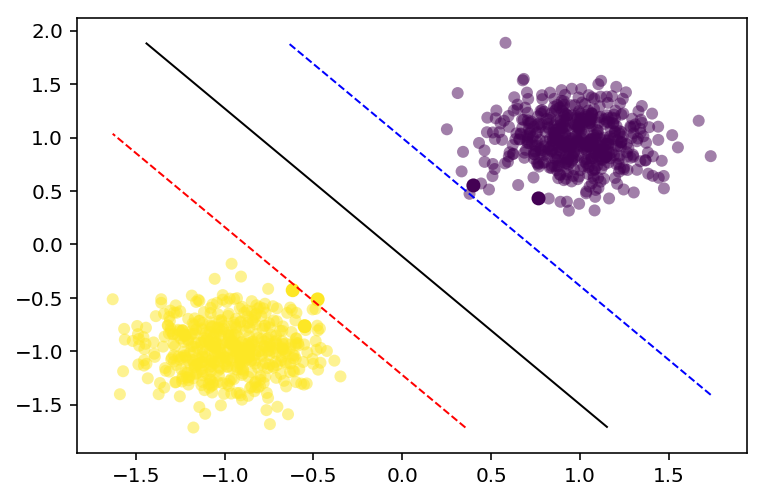

In [57]:
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)

In [58]:
X_train, y = make_circles(n_samples=500, noise=0.1,
                          factor=0.1, random_state=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y)
y[y == 0] = -1

In [59]:

# Set model parameters and initial values
C = 1.0
m = len(X_train_scaled)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Instantiate model
model = SMOModel(X_train_scaled, y, C, gaussian_kernel,
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error

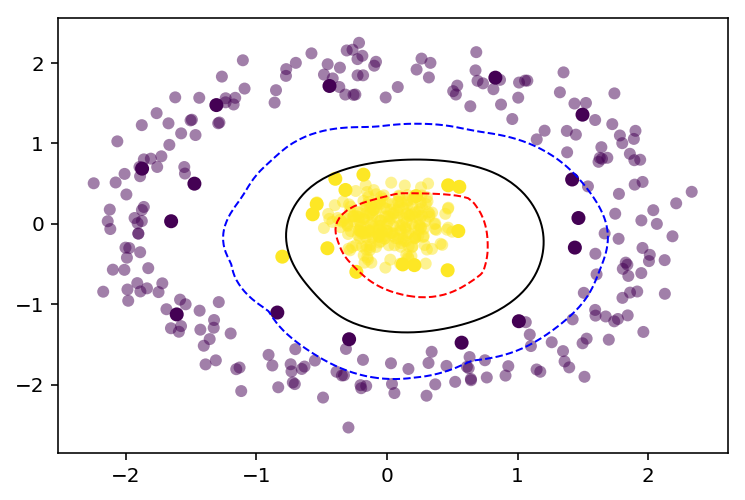

In [60]:

output = train(model)
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)